In [1]:
import numpy as np
import pandas as pd
import time, os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [2]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, adjusted_mutual_info_score
from sklearn.metrics import multilabel_confusion_matrix

In [3]:
import tcremb.ml_utils as ml_utils
import benchmark.models as models
import benchmark.metrics as metrics
#import benchmark.models_tcrdist as models_tcrdist

# Clustering

## VDJdb

In [4]:
vdjdb_data_path = '/home/ykremlyakova/projects/tcr_emb/data/data_preped/VDJdb_data.csv'

In [5]:

vdjdb_data = pd.read_csv(vdjdb_data_path,sep='\t')

In [6]:
label = 'antigen.epitope'
label_s = 'antigen.species'
#label = 'antigen.species_freq'
#output_suf = 'vdjdb_freq'
output_suf = 'vdjdb'
output_suf_s = 'vdjdb_s'

In [ ]:
def tcrdist3_dist(data_df, chain, n_clusters=None, chunk=True):
    df = data_df.copy()
    cdr3a = 'cdr3_a_aa'
    va = 'v_a_gene'
    ja = 'j_a_gene'
    cdr3b = 'cdr3_b_aa'
    vb = 'v_b_gene'
    jb = 'j_b_gene'

    if not 'count' in df.columns:
        df['count']=[1]*len(df)

    if chain == 'TRA':
        df = df[df['chain']==chain].reset_index(drop=True)
        df = df.rename(columns={'cdr3aa': cdr3a,
                                                'v': va,
                                                'j':ja})
        df = df[[cdr3a, va, ja,'antigen.epitope', 'count','data_id']]

    elif chain == 'TRB':
        df = df[df['chain']==chain].reset_index(drop=True)
        df= df.rename(columns={'cdr3aa': cdr3b,
                                                'v': vb,
                                                'j':jb})
        df = df[[cdr3b, vb, jb,'antigen.epitope', 'count','data_id']]

    else:
        pass


    seqs = df.drop(columns=['antigen.epitope','data_id'], axis=1).reset_index(drop=True)

    if chain =='TRA':
        chain1 = ['alpha']
    else:
        chain1 = ['beta']

    # Run tcrdist3

    print('\n*** Tcrdist3 clustering %s %s chains ' % (len(seqs), chain))

    t0 = time.time()

    # Create tcrdist object
    tr = TCRrep(cell_df=seqs,   # Input data
                organism='human',   # Organism
                chains=chain1,       # Chain selection
                infer_all_genes=True,   # Infer genes
                infer_cdrs=True,        # Infer CDRs
                infer_index_cols=True,  # Infer column names
                store_all_cdr=True,     # Store CDRs
                deduplicate=False,      # Deduplicate
                compute_distances=False)    # Compute distances
    return tr, df
    
    # Compute tcrdist distances using sparse rect distances
def tcrdist3_compute(tr, chain, cpus, radius=50):
    if chain =='TRA':
        chain1 = ['alpha']
        name = 'alpha'
    else:
        chain1 = ['beta']
        name = 'beta'


    S, _ = compute_pw_sparse_out_of_memory2(tr = tr,
        row_size      = 50,
        pm_processes  = cpus,
        pm_pbar       = True,
        max_distance  = radius,
        reassemble    = True,
        cleanup       = True,
        assign        = True)
    S=S[name]

    return S   

    # Cluster tcrdist matrix
def tcrdust3_cluster(S, chain, n_clusters):
    if not n_clusters:
        n_clusters=500
    kmeans = KMeans(init='random',
                    n_init=10,
                    n_clusters=int(n_clusters)).fit(S)
    labels = kmeans.labels_
    
    pd.DataFrame(labels).to_csv()

    return labels

def run_tcrdist3(vdjdb_data_tcrdist3, chain, n_clusters):
    tcrdist3_tr, tcrdist_data = tcrdist3_dist(vdjdb_data_tcrdist3,chain)
    tcrdist3_s = tcrdist3_compute(tcrdist3_tr,chain,2)
    tcrdist3_labels = tcrdust3_cluster(tcrdist3_s, chain, n_clusters)
    tcrdist_data['cluster']= tcrdist3_labels
    binom_res = ml_utils.binominal_test(tcrdist_data, 'cluster', 'antigen.epitope')
    binom_res = binom_res.rename({'antigen.epitope':'label_cluster'},axis=1)
    tcrdist_data = tcrdist_data.merge(binom_res)
    tcrdist_data.to_csv(f'benchmark/outputs/tcrdist_res_{chain}.txt',sep='\t')
    return tcrdist_data


def run_GIANA(data_df, chain, cpus):
    '''Run GIANA clustering algorithm
'''
    df = data_df[data_df['chain']==chain][['cdr3aa','v','antigen.epitope','data_id']].reset_index(drop=True)
    df = df.rename({'cdr3aa':'CDR3','v':'V'},axis=1)
    # Reformat input for GIANA
    seqs = df[['CDR3','V']]

    #save data for GIANA
    cdir = os.getcwd()
    giana_path = os.path.join(cdir, 'benchmark/GIANA/')
    os.chdir(giana_path)
    seqs.to_csv('data.txt', index=False, header=False, sep='\t')
    print('GIANA clustering of {} sequences.'.format(len(df)))

    # Run GIANA
    t0 = time.time()
    os.system('python GIANA4.1.py -f data.txt -O data_clustered.txt -v True -N {}'.format(cpus))
    t1 = time.time()
    t = t1 - t0

    print('Elapsed time: {} seconds.'.format(t))

    with open(os.path.join(giana_path, 'data_clustered.txt'), 'r') as f:
        results = f.read().splitlines()[3:]
        results = pd.DataFrame([x.split('\t') for x in results], columns=['CDR3',
                                                                            'cluster',
                                                                            'V',
                                                                         ])   
    os.chdir(cdir)
    
    giana_data = pd.merge(df, results.drop_duplicates(),on=['CDR3','V'])
    
    binom_res = ml_utils.binominal_test(giana_data, 'cluster', 'antigen.epitope')
    binom_res = binom_res.rename({'antigen.epitope':'label_cluster'},axis=1)
    giana_data = giana_data.merge(binom_res)
    giana_data.to_csv(f'benchmark/outputs/giana_res_{chain}.txt',sep='\t')

    return giana_data

In [ ]:
def run_ismart(data_df, chain_selection,cpus):
    
    df = data_df[data_df['chain']==chain][['cdr3aa','v','antigen.epitope','data_id']].reset_index(drop=True)
    df = df.rename({'cdr3aa':'CDR3','v':'V'},axis=1)
    
    # Reformat input for iSMART
    seqs = df[['CDR3','V']]

    #save data for iSMART
    cdir = os.getcwd()
    ismart_path = os.path.join(cdir, 'benchmark/iSMART/')
    os.chdir(ismart_path)
    seqs.to_csv('data.txt', index=False, header=False, sep='\t')
    print('Clustering {} sequences with iSMART.'.format(len(df)))
    
    
    t0 = time.time()
    #os.system('python iSMARTf3.py -f input.txt -v True -N {}'.format(cpus))
    os.system('python iSMARTf3.py -f data.txt')
    t1 = time.time()
    t = t1 - t0
    
    
    print('Elapsed time: {} seconds.'.format(t))

    with open(os.path.join(ismart_path, 'data_clustered_v3.txt'), 'r') as f:
        results = f.read().splitlines()[3:]
        results = pd.DataFrame([x.split('\t') for x in results], columns=['CDR3',
                                                                            'V',
                                                                            'cluster',
                                                                         ])   
    os.chdir(cdir)
    
    ismart_data = pd.merge(df, results.drop_duplicates(),on=['CDR3','V'])
    
    binom_res = ml_utils.binominal_test(ismart_data, 'cluster', 'antigen.epitope')
    binom_res = binom_res.rename({'antigen.epitope':'label_cluster'},axis=1)
    ismart_data = ismart_data.merge(binom_res)
    ismart_data.to_csv(f'benchmark/outputs/ismart_res_{chain}.txt',sep='\t')

    return ismart_data

### TCRDIST3

In [ ]:
vdjdb_data_tcrdist3 = vdjdb_data.copy()
vdjdb_data_tcrdist3['v']= vdjdb_data_tcrdist3['v'] + '*01'
vdjdb_data_tcrdist3['j']= vdjdb_data_tcrdist3['j'] + '*01'
vdjdb_data_tcrdist3['v'] = vdjdb_data_tcrdist3['v'].str.replace('DV','/DV')
vdjdb_data_tcrdist3

In [ ]:
tcrdist_res = {}
metrics_tcrdist = {}

In [ ]:
chain = 'TRA'
tcrdist_res[chain] = run_tcrdist3(vdjdb_data_tcrdist3,chain, n_clusters=5295)

In [ ]:
chain = 'TRB'
tcrdist_res[chain] = run_tcrdist3(vdjdb_data_tcrdist3,chain, n_clusters=10616)

In [ ]:
chain = 'TRA'
tcrdist_res[chain]=pd.read_csv(f'benchmark/outputs/tcrdist_res_{chain}.txt',sep='\t')

In [ ]:
print(ml_utils.clsf_metrics(tcrdist_res[chain]['antigen.epitope'],tcrdist_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcrdist_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
chain = 'TRB'
tcrdist_res[chain]=pd.read_csv(f'benchmark/outputs/tcrdist_res_{chain}.txt',sep='\t')
tcrdist_res[chain]['is_cluster'] = tcrdist_res[chain]['total_cluster'].apply(lambda x: 1 if x>1 else 0)

In [ ]:
print(ml_utils.clsf_metrics(tcrdist_res[chain]['antigen.epitope'],tcrdist_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcrdist_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
chain = 'TRA'
metrics_tcrdist[chain] = metrics.get_clustermetrics(tcrdist_res[chain], 'antigen.epitope')
metrics_tcrdist[chain]

In [ ]:
chain = 'TRB'
metrics_tcrdist[chain] = metrics.get_clustermetrics(tcrdist_res[chain], 'antigen.epitope')
metrics_tcrdist[chain]

### GIANA

In [ ]:
vdjdb_data_giana = vdjdb_data.copy()
vdjdb_data_giana['v']= vdjdb_data_giana['v'] + '*01'
vdjdb_data_giana['j']= vdjdb_data_giana['j'] + '*01'
vdjdb_data_giana

In [ ]:
giana_res_raw = {}
giana_res= {}
metrics_giana = {}


In [ ]:
#giana_res_raw_s = {}
#giana_res_s= {}
metrics_giana_s = {}

In [ ]:

chain = 'TRA'
giana_res_raw[chain] = models.run_GIANA(vdjdb_data_giana, chain,output_suf=output_suf,label = label)

In [ ]:

chain = 'TRA'
giana_res_raw[chain] = models.run_GIANA(vdjdb_data_giana, chain,output_suf=output_suf_s,label = label_s)

In [ ]:
chain = 'TRB'
giana_res_raw[chain] = models.run_GIANA(vdjdb_data_giana, chain,output_suf=output_suf,label = label)

In [ ]:
chain = 'TRB'
giana_res_raw[chain] = models.run_GIANA(vdjdb_data_giana, chain,output_suf=output_suf_s,label = label_s)

#### metrics epitope

In [ ]:
chain = 'TRA'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_{output_suf}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label]].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)

In [ ]:
print(ml_utils.clsf_metrics(giana_res_raw[chain][label],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_giana[chain] = metrics.get_clustermetrics(giana_res[chain], label)
metrics_giana[chain]

In [ ]:
chain = 'TRB'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_{output_suf}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label]].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)

In [ ]:
print(ml_utils.clsf_metrics(giana_res_raw[chain][label],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_giana[chain] = metrics.get_clustermetrics(giana_res[chain], label)
metrics_giana[chain]

#### metrics species

In [ ]:
chain = 'TRA'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_{output_suf_s}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label_s]].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(giana_res_raw[chain][label_s],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_giana_s[chain] = metrics.get_clustermetrics(giana_res[chain], label_s)
metrics_giana_s[chain]

In [ ]:
chain = 'TRB'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_{output_suf_s}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label_s]].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(giana_res_raw[chain][label_s],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_giana_s[chain] = metrics.get_clustermetrics(giana_res[chain], label_s)
metrics_giana_s[chain]

### TCRemb

In [ ]:
tcremb_res = {}
metrics_tcremb= {}

tcremb_res_dbscan = {}
metrics_tcremb_s= {}
metrics_tcremb_dbscan= {}
metrics_tcremb_dbscan_s= {}
output_suf_dbscan = output_suf + '_dbscan'
output_suf_dbscan_s = output_suf + '_dbscan_s'

In [ ]:
chain = 'TRA'
tcremb_res[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf,skip_scores=True, label=label)

In [ ]:
chain = 'TRA'
tcremb_res[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_s,skip_scores=True, label=label_s)

In [ ]:
chain = 'TRA'
tcremb_res_dbscan[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_dbscan, skip_scores=True, label=label, model='dbscan')

In [ ]:
chain = 'TRA'
tcremb_res_dbscan[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_dbscan_s,skip_scores=True, label=label_s, model='dbscan')

In [ ]:
chain = 'TRB'
tcremb_res[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf,skip_scores=True, label=label)

In [ ]:
chain = 'TRB'
tcremb_res[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_s,skip_scores=True, label=label_s)

In [ ]:
chain = 'TRB'
tcremb_res_dbscan[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_dbscan,skip_scores=True ,label=label, model='dbscan')

In [ ]:
chain = 'TRB'
tcremb_res_dbscan[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_dbscan_s,skip_scores=True, label=label_s, model='dbscan')

#### metrics epitope

In [ ]:
chain = 'TRA'
run_name = f'compare_{output_suf}'
tcremb_res[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res[chain][label],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb[chain] = metrics.get_clustermetrics(tcremb_res[chain], label)
metrics_tcremb[chain]

In [ ]:
chain = 'TRA'
run_name = f'compare_{output_suf_dbscan}'
tcremb_res_dbscan[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res_dbscan[chain][label],tcremb_res_dbscan[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res_dbscan[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_dbscan[chain] = metrics.get_clustermetrics(tcremb_res_dbscan[chain], label)
metrics_tcremb_dbscan[chain]

In [ ]:
chain = 'TRB'
run_name = f'compare_{output_suf}'
tcremb_res[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res[chain][label],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb[chain] = metrics.get_clustermetrics(tcremb_res[chain], label)
metrics_tcremb[chain]

In [ ]:
chain = 'TRB'
run_name = f'compare_{output_suf_dbscan}'
tcremb_res_dbscan[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res_dbscan[chain][label],tcremb_res_dbscan[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res_dbscan[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_dbscan[chain] = metrics.get_clustermetrics(tcremb_res_dbscan[chain], label)
metrics_tcremb_dbscan[chain]

#### metrics species

In [ ]:
chain = 'TRA'
run_name = f'compare_{output_suf_s}'
tcremb_res[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res[chain][label_s],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_s[chain] = metrics.get_clustermetrics(tcremb_res[chain], label_s)
metrics_tcremb_s[chain]

In [ ]:
chain = 'TRA'
run_name = f'compare_{output_suf_dbscan_s}'
tcremb_res_dbscan[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res_dbscan[chain][label_s],tcremb_res_dbscan[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res_dbscan[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_dbscan_s[chain] = metrics.get_clustermetrics(tcremb_res_dbscan[chain], label_s)
metrics_tcremb_dbscan_s[chain]

In [ ]:
chain = 'TRB'
run_name = f'compare_{output_suf_s}'
tcremb_res[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res[chain][label_s],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_s[chain] = metrics.get_clustermetrics(tcremb_res[chain], label_s)
metrics_tcremb_s[chain]

In [ ]:
chain = 'TRB'
run_name = f'compare_{output_suf_dbscan_s}'
tcremb_res_dbscan[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res_dbscan[chain][label_s],tcremb_res_dbscan[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res_dbscan[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_dbscan_s[chain] = metrics.get_clustermetrics(tcremb_res_dbscan[chain], label_s)
metrics_tcremb_dbscan_s[chain]

#### check tcremb and ismart

In [ ]:
tcremb_t = tcremb_res[chain].copy()

In [ ]:
t = ismart_res[chain][~ismart_res[chain]['cluster'].isna()]

In [ ]:
len(t['cluster'].drop_duplicates())

In [ ]:
tcremb_t = tcremb_t[tcremb_t['data_id'].isin(t['data_id'])]
tcremb_t

In [ ]:
len(tcremb_t['cluster'].drop_duplicates())

In [ ]:
print(ml_utils.clsf_metrics(tcremb_t[label],tcremb_t['label_cluster'], average='weighted'))

In [ ]:
tcremb_t.sort_values('total_cluster')

In [ ]:
tcremb_res_pred_between = {}
metrics_tcremb_pred_between= {}

In [ ]:
chain = 'TRA'
#tcremb_res_pred_enriched_between[chain] = pd.read_csv(f'benchmark/outputs/tcremb_res_pred_enriched_between_{chain}.txt', sep='\t')
tcremb_res_pred_between[chain] = tcremb_res[chain].copy()
tcremb_res_pred_between[chain]['is_cluster']=tcremb_res_pred_between[chain]['is_cluster_between']

In [ ]:
metrics_tcremb_pred_between[chain] = metrics.get_clustermetrics(tcremb_res_pred_between[chain], label)
metrics_tcremb_pred_between[chain]

In [ ]:
chain = 'TRB'
#tcremb_res_pred_enriched_between[chain] = pd.read_csv(f'benchmark/outputs/tcremb_res_pred_enriched_between_{chain}.txt', sep='\t')
tcremb_res_pred_between[chain] = tcremb_res[chain].copy()
tcremb_res_pred_between[chain]['is_cluster']=tcremb_res_pred_between[chain]['is_cluster_between']

In [ ]:
metrics_tcremb_pred_between[chain] = metrics.get_clustermetrics(tcremb_res_pred_between[chain], label)
metrics_tcremb_pred_between[chain]

### iSMART

In [ ]:
ismart_res_raw = {}
ismart_res= {}
metrics_ismart = {}
metrics_ismart_s = {}

In [ ]:
os.chdir('/home/ykremlyakova/projects/tcr_emb/')

In [ ]:
chain = 'TRA'
ismart_res_raw[chain] = models.run_ismart(vdjdb_data_giana, chain,output_suf=output_suf,label = label)

In [ ]:
chain = 'TRA'
ismart_res_raw[chain] = models.run_ismart(vdjdb_data_giana, chain,output_suf=output_suf_s,label = label_s)

In [ ]:

chain = 'TRB'
ismart_res_raw[chain] = models.run_ismart(vdjdb_data_giana, chain,output_suf=output_suf,label = label)

In [ ]:

chain = 'TRB'
ismart_res_raw[chain] = models.run_ismart(vdjdb_data_giana, chain,output_suf=output_suf_s,label = label_s)

#### metrics epitope

In [ ]:
chain = 'TRA'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_{output_suf}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label]].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(ismart_res_raw[chain][label],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_ismart[chain] = metrics.get_clustermetrics(ismart_res[chain], label)
metrics_ismart[chain]

In [ ]:
chain = 'TRB'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_{output_suf}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label]].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(ismart_res_raw[chain][label],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_ismart[chain] = metrics.get_clustermetrics(ismart_res[chain], label)
metrics_ismart[chain]

#### metrics species

In [ ]:
chain = 'TRA'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_{output_suf_s}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label_s]].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(ismart_res_raw[chain][label_s],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_ismart_s[chain] = metrics.get_clustermetrics(ismart_res[chain], label_s)
metrics_ismart_s[chain]

In [ ]:
chain = 'TRB'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_{output_suf_s}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label_s]].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(ismart_res_raw[chain][label_s],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_ismart_s[chain] = metrics.get_clustermetrics(ismart_res[chain], label_s)
metrics_ismart_s[chain]

In [ ]:
ismart_res[chain]['len']=ismart_res[chain]['cdr3aa'].apply(len)

In [ ]:
ismart_res[chain][-ismart_res[chain]['cluster'].isna()]

In [ ]:
sns.distplot(ismart_res[chain][-ismart_res[chain]['cluster'].isna()]['len'])

In [ ]:
chain = 'TRA'
metrics_ismart[chain] = metrics.get_clustermetrics(ismart_res[chain], label)
metrics_ismart[chain]

In [ ]:
chain = 'TRB'
metrics_ismart[chain] = metrics.get_clustermetrics(ismart_res[chain], label)
metrics_ismart[chain]

### Compare metrics

In [ ]:
metrics_res = {}

In [ ]:
chain = 'TRA'
metrics_res[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb[chain], index=['TCRemb'])])
metrics_res[chain]['method'] = metrics_res[chain].index

chain = 'TRB'
metrics_res[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb[chain], index=['TCRemb'])])
metrics_res[chain]['method'] = metrics_res[chain].index

In [ ]:
sns.color_palette("Set2")

In [ ]:
print(sns.color_palette("Set2").as_hex())

In [ ]:
color_map = {'tcrdist':'#fc8d62','GIANA':'#e78ac3','iSMART':'#a6d854','TCRemb':'#66c2a5'}

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_res[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[0,0].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_res[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[1,0].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_res[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[2,0].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_res[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[0,1].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_res[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[1,1].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_res[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[2,1].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

plt.savefig(f"figures/fig4.png")

In [ ]:
metrics_res_2 = {}

In [ ]:
chain = 'TRA'
metrics_res_2[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_dbscan[chain], index=['TCRemb'])])
metrics_res_2[chain]['method'] = metrics_res_2[chain].index

chain = 'TRB'
metrics_res_2[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_dbscan[chain], index=['TCRemb'])])
metrics_res_2[chain]['method'] = metrics_res_2[chain].index

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[0,0].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,0].set_title(f'Purity {chain}')

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[1,0].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,0].set_title(f'F1-score {chain}')   

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[2,0].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,0].set_title(f'Retention {chain}') 

chain = 'TRB'

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[0,1].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,1].set_title(f'Purity {chain}')

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[1,1].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,1].set_title(f'F1-score {chain}')   

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[2,1].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,1].set_title(f'Retention {chain}')   

plt.savefig(f"figures/fig4_2.png")

In [ ]:
metrics_3 = {}

In [ ]:
chain = 'TRA'
metrics_3[chain] = pd.concat([
    #pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist']),
    pd.DataFrame(metrics_giana_s[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart_s[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_s[chain], index=['TCRemb'])])
metrics_3[chain]['method'] = metrics_3[chain].index

chain = 'TRB'
metrics_3[chain] = pd.concat([
    #pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist']),
    pd.DataFrame(metrics_giana_s[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart_s[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_s[chain], index=['TCRemb'])])
metrics_3[chain]['method'] = metrics_3[chain].index

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_3[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[0,0].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[1,0].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,0].set_title(f'F1-score {chain}')
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[2,0].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_3[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[0,1].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[1,1].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[2,1].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,1].set_title(f'Retention {chain}')   
axes[2,1].set_ylim(0, 1)

plt.savefig(f"figures/fig4_3.png")

## VDJdb V10-V1000

In [7]:
samples_n = [10,50,100,500,1000]
#samples_n = [1000]

In [8]:
tcrdist_res_v = {}
metrics_tcrdist_v = {}

giana_res_raw_v = {}
giana_res_v = {}
metrics_giana_v = {}

ismart_res_raw_v = {}
ismart_res_v = {}
metrics_ismart_v = {}

tcremb_res_v = {}
metrics_tcremb_v = {}

tcremb_res_v_dbscan = {}
metrics_tcremb_v_dbscan = {}

metrics_tcremb_v_all_clstr = {}
metrics_tcremb_v_enriched = {}

### TCRDIST3

In [ ]:
chain = 'TRA'
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    vdjdb_v['v'] = vdjdb_v['v'].str.replace('DV','/DV')
    print(len(vdjdb_v))
    
    tcrdist_res[chain] = run_tcrdist3(vdjdb_data_tcrdist3,chain, n_clusters=5295)

### ismart

In [ ]:
## Run ismart
chain = 'TRA'
for i in samples_n:
    ismart_res_raw_v[i]={}
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    ismart_res_raw_v[i][chain] = models.run_ismart(vdjdb_v, chain, f'V{i}',2)
    


In [ ]:
## Run ismart
chain = 'TRB'
for i in samples_n:
    ismart_res_raw_v[i]={}
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    ismart_res_raw_v[i][chain] = models.run_ismart(vdjdb_v, chain, f'V{i}',2)
    


In [9]:
## work with results
chain = 'TRA'
ismart_res_raw_v[chain]={}
ismart_res_v[chain]={}
metrics_ismart_v[chain]={}

for i in samples_n:
    ismart_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    ismart_res_v[chain][i] = vdjdb_v[vdjdb_v['chain']==chain][['chain','data_id','cdr3aa','v','antigen.epitope']].merge(ismart_res_raw_v[chain][i], how = 'left')
    ismart_res_v[chain][i]['is_cluster'] = ismart_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(ismart_res_raw_v[chain][i]['antigen.epitope'],ismart_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(ismart_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_ismart_v[chain][i] = metrics.get_clustermetrics(ismart_res_v[chain][i], 'antigen.epitope')
    metrics_ismart_v[chain][i]['method']='iSmart'
    print(metrics_ismart_v[chain][i])

TCR-epitope paires count in V10 dataset: 10352
{'f1': 0.7989197956940378, 'precision': 0.8066755109473737, 'recall': 0.8028998640688718}
0.8028998640688718


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.8028998640688718, 'retention': 0.21319551777434312, 'consistency': 0.0024254377781923824, 'ami': 0.6792427097713462, 'accuracy': 0.001809130194756602, 'precision': 0.8066755109473737, 'recall': 0.8028998640688721, 'f1-score': 0.8047832591633642, 'support': 2207, 'mean_clustsize': 3.2455882352941177, 'method': 'iSmart'}
TCR-epitope paires count in V50 dataset: 9259
{'f1': 0.8298245726810306, 'precision': 0.8380512560994907, 'recall': 0.8292170257488176}
0.8292170257488176
{'purity': 0.8292170257488176, 'retention': 0.20552975483313532, 'consistency': 0.0051234892275354715, 'ami': 0.6875189510586341, 'accuracy': 0.11717455830037425, 'precision': 0.8380512560994906, 'recall': 0.8292170257488176, 'f1-score': 0.8336107362847394, 'support': 1903, 'mean_clustsize': 3.33859649122807, 'method': 'iSmart'}
TCR-epitope paires count in V100 dataset: 8648
{'f1': 0.8487542126536403, 'precision': 0.8510647686295968, 'recall': 0.8504027617951668}
0.8504027617951668
{'purity': 0.85040276179

In [10]:
## work with results
chain = 'TRB'
ismart_res_raw_v[chain]={}
ismart_res_v[chain]={}
metrics_ismart_v[chain]={}

for i in samples_n:
    ismart_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    ismart_res_v[chain][i] = vdjdb_v[vdjdb_v['chain']==chain][['chain','data_id','cdr3aa','v','antigen.epitope']].merge(ismart_res_raw_v[chain][i], how = 'left')
    ismart_res_v[chain][i]['is_cluster'] = ismart_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(ismart_res_raw_v[chain][i]['antigen.epitope'],ismart_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(ismart_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_ismart_v[chain][i] = metrics.get_clustermetrics(ismart_res_v[chain][i], 'antigen.epitope')
    metrics_ismart_v[chain][i]['method']='iSmart'
    print(metrics_ismart_v[chain][i])

TCR-epitope paires count in V10 dataset: 22057
{'f1': 0.8475415917017777, 'precision': 0.8524283813561937, 'recall': 0.8581750066898581}
0.8581750066898581


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.8581750066898581, 'retention': 0.16942467243958834, 'consistency': 0.0014481575343543893, 'ami': 0.8324035243082634, 'accuracy': 0.0034684864894939686, 'precision': 0.8524283813561941, 'recall': 0.8581750066898577, 'f1-score': 0.8552920413756162, 'support': 3737, 'mean_clustsize': 3.4252978918423467, 'method': 'iSmart'}
TCR-epitope paires count in V50 dataset: 19791
{'f1': 0.8684105902348268, 'precision': 0.8713125038692191, 'recall': 0.8725728155339806}
0.8725728155339806


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.8725728155339806, 'retention': 0.16654034662220202, 'consistency': 0.002552396363075975, 'ami': 0.8313900323763072, 'accuracy': 0.0039310115526911115, 'precision': 0.8713125038692193, 'recall': 0.8725728155339804, 'f1-score': 0.8719422042859041, 'support': 3296, 'mean_clustsize': 3.4878306878306877, 'method': 'iSmart'}
TCR-epitope paires count in V100 dataset: 18072
{'f1': 0.8895233708938829, 'precision': 0.8946058743307275, 'recall': 0.8928203366540708}
0.8928203366540708
{'purity': 0.8928203366540708, 'retention': 0.16107791057990262, 'consistency': 0.003914371982859932, 'ami': 0.8446002461907535, 'accuracy': 0.004447409882626944, 'precision': 0.8946058743307276, 'recall': 0.8928203366540707, 'f1-score': 0.8937122136668303, 'support': 2911, 'mean_clustsize': 3.620646766169154, 'method': 'iSmart'}
TCR-epitope paires count in V500 dataset: 11184
{'f1': 0.963801910117599, 'precision': 0.9641182977198806, 'recall': 0.9638839550029603}
0.9638839550029603
{'purity': 0.96388395

### GIANA

In [ ]:
## Run Giana
chain = 'TRA'
giana_res_raw_v[chain]={}
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_raw_v[chain][i] = models.run_GIANA(vdjdb_v, chain, f'V{i}',2)
    


In [ ]:
## Run Giana
chain = 'TRB'
giana_res_raw_v[chain]={}
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_raw_v[chain][i] = models.run_GIANA(vdjdb_v, chain, f'V{i}',2)
    


In [11]:
## work with results
chain = 'TRA'
giana_res_raw_v[chain]={}
giana_res_v[chain]={}
metrics_giana_v[chain]={}
for i in samples_n:
    giana_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_v[chain][i] = vdjdb_v[vdjdb_v['chain']==chain][['chain','data_id','cdr3aa','v','antigen.epitope']].merge(giana_res_raw_v[chain][i], how = 'left')
    giana_res_v[chain][i]['is_cluster'] = giana_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(giana_res_raw_v[chain][i]['antigen.epitope'],giana_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(giana_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_giana_v[chain][i] = metrics.get_clustermetrics(giana_res_v[chain][i], 'antigen.epitope')
    metrics_giana_v[chain][i]['method']='GIANA'
    print(metrics_giana_v[chain][i])

TCR-epitope paires count in V10 dataset: 10352
{'f1': 0.5227617295274909, 'precision': 0.5461768198064888, 'recall': 0.548778213019959}
0.548778213019959


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.548778213019959, 'retention': 0.517870942812983, 'consistency': 0.001279420697439724, 'ami': 0.30376688325432744, 'accuracy': 0.001117732818641796, 'precision': 0.5461768198064889, 'recall': 0.5487782130199589, 'f1-score': 0.5474744262193583, 'support': 5361, 'mean_clustsize': 4.9730983302411875, 'method': 'GIANA'}
TCR-epitope paires count in V50 dataset: 9259
{'f1': 0.5722748334298549, 'precision': 0.5886703194692913, 'recall': 0.5859324585932458}
0.5859324585932458
{'purity': 0.5859324585932458, 'retention': 0.5021060589696511, 'consistency': 0.0030574931628921742, 'ami': 0.3129181087615778, 'accuracy': 0.0739096906561874, 'precision': 0.5886703194692914, 'recall': 0.5859324585932458, 'f1-score': 0.5872981982154811, 'support': 4649, 'mean_clustsize': 4.857889237199582, 'method': 'GIANA'}
TCR-epitope paires count in V100 dataset: 8648
{'f1': 0.598793952128795, 'precision': 0.6165793965555366, 'recall': 0.6112925804946336}
0.6112018669778296
{'purity': 0.6112018669778296, 

In [12]:
## work with results
chain = 'TRB'
giana_res_raw_v[chain]={}
giana_res_v[chain]={}
metrics_giana_v[chain]={}
for i in samples_n:
    giana_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_v[chain][i] = vdjdb_v[vdjdb_v['chain']==chain][['chain','data_id','cdr3aa','v','antigen.epitope']].merge(giana_res_raw_v[chain][i], how = 'left')
    giana_res_v[chain][i]['is_cluster'] = giana_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(giana_res_raw_v[chain][i]['antigen.epitope'],giana_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(giana_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_giana_v[chain][i] = metrics.get_clustermetrics(giana_res_v[chain][i], 'antigen.epitope')
    metrics_giana_v[chain][i]['method']='GIANA'
    
    print(metrics_giana_v[chain][i])

TCR-epitope paires count in V10 dataset: 22057
{'f1': 0.7193003389680143, 'precision': 0.7249899616436254, 'recall': 0.7337136547662864}
0.7337136547662864


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.7337136547662864, 'retention': 0.24636169923380333, 'consistency': 0.0009573893978156169, 'ami': 0.6366612223330667, 'accuracy': 0.003119239012154961, 'precision': 0.7249899616436257, 'recall': 0.7337136547662855, 'f1-score': 0.7293257224323414, 'support': 5434, 'mean_clustsize': 3.5171521035598707, 'method': 'GIANA'}
TCR-epitope paires count in V50 dataset: 19791
{'f1': 0.7526459916736051, 'precision': 0.7598913887165964, 'recall': 0.7607232968881413}
0.7607232968881413
{'purity': 0.7607232968881413, 'retention': 0.2403112525895609, 'consistency': 0.0021059447047672443, 'ami': 0.6497707226753061, 'accuracy': 0.0033521465692311282, 'precision': 0.7598913887165966, 'recall': 0.7607232968881412, 'f1-score': 0.760307115239393, 'support': 4756, 'mean_clustsize': 3.5334323922734026, 'method': 'GIANA'}
TCR-epitope paires count in V100 dataset: 18072
{'f1': 0.7731527160808344, 'precision': 0.7780485863172668, 'recall': 0.7799476065729936}
0.7799476065729936
{'purity': 0.779947606

### TCRemb

In [ ]:
chain = 'TRA'
tcremb_res_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}',skip_scores=True)

In [ ]:
chain = 'TRA'
tcremb_res_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}_dbscan',skip_scores=True, model='dbscan')

In [ ]:
chain = 'TRB'
tcremb_res_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}',skip_scores=True)

In [ ]:
chain = 'TRB'
tcremb_res_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}_dbscan',skip_scores=True, model='dbscan')

In [ ]:
pd.DataFrame(metrics_tcremb_v_dbscan['TRA']).T

In [13]:
## work with results
chain = 'TRA'
tcremb_res_v[chain]={}
metrics_tcremb_v[chain]={}
metrics_tcremb_v_all_clstr[chain]={}
metrics_tcremb_v_enriched[chain] = {}
for i in samples_n:
    tcremb_res_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_v[chain][i])}")
    
    print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v[chain][i]['method']='TCRemb'
    
    tcremb_res_v_i = tcremb_res_v[chain][i].copy()
    tcremb_res_v_i['is_cluster']=tcremb_res_v_i['total_cluster'].apply(lambda x: 1 if x >1 else 0)
    
    metrics_tcremb_v_all_clstr[chain][i] = metrics.get_clustermetrics(tcremb_res_v_i, 'antigen.epitope')
    metrics_tcremb_v_all_clstr[chain][i]['method']='TCRemb'
    
    tcremb_res_v_i['is_cluster']=tcremb_res_v_i.apply(lambda x: 1 if (x['total_cluster']>1) & (x['fraction_matched']>=0.7) else 0,axis=1)
    metrics_tcremb_v_enriched[chain][i] = metrics.get_clustermetrics(tcremb_res_v_i, 'antigen.epitope')
    metrics_tcremb_v_enriched[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v[chain][i])

TCR-epitope paires count in V10 dataset: 10341
{'f1': 0.6807346016595247, 'precision': 0.6849985639557399, 'recall': 0.6862005608741901}
0.7401041666666667
{'purity': 0.7401041666666667, 'retention': 0.18566869741804468, 'consistency': 0.0018835616438356165, 'ami': 0.5880820942303202, 'accuracy': 0.0005205620659722223, 'precision': 0.7335337329765877, 'recall': 0.7401041666666668, 'f1-score': 0.7368043021938462, 'support': 1920, 'mean_clustsize': 3.2432432432432434, 'method': 'TCRemb'}
TCR-epitope paires count in V50 dataset: 9249
{'f1': 0.6790103760476489, 'precision': 0.680743679018854, 'recall': 0.6845064331279057}
0.7578125
{'purity': 0.7578125, 'retention': 0.26294734565899014, 'consistency': 0.003230733082706766, 'ami': 0.561441480381192, 'accuracy': 0.08593073710180055, 'precision': 0.7580973292708784, 'recall': 0.7578124999999999, 'f1-score': 0.757954887876686, 'support': 2432, 'mean_clustsize': 3.545189504373178, 'method': 'TCRemb'}
TCR-epitope paires count in V100 dataset: 86

In [14]:
## work with results
chain = 'TRA'
tcremb_res_v[chain]={}
metrics_tcremb_v_dbscan[chain]={}
for i in samples_n:
    tcremb_res_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}_dbscan/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_v[chain][i])}")
    
    print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v_dbscan[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v_dbscan[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v_dbscan[chain][i])

TCR-epitope paires count in V10 dataset: 10341
{'f1': 0.32792987516115474, 'precision': 0.6620324091089255, 'recall': 0.3720143119620926}
0.8024747937671861


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.8024747937671861, 'retention': 0.21100473841988202, 'consistency': 0.002207562515330295, 'ami': 0.6703228538427611, 'accuracy': 0.0018281397417920643, 'precision': 0.8069971767646765, 'recall': 0.8024747937671864, 'f1-score': 0.8047296316455049, 'support': 2182, 'mean_clustsize': 3.190058479532164, 'method': 'TCRemb'}
TCR-epitope paires count in V50 dataset: 9249
{'f1': 0.3509235526584758, 'precision': 0.6905017505267138, 'recall': 0.39993512812195914}
0.831230283911672


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.831230283911672, 'retention': 0.20564385338955563, 'consistency': 0.004525311701967854, 'ami': 0.6841668734053117, 'accuracy': 0.12518340868707578, 'precision': 0.8310695009402953, 'recall': 0.8312302839116719, 'f1-score': 0.831149884650261, 'support': 1902, 'mean_clustsize': 3.256849315068493, 'method': 'TCRemb'}
TCR-epitope paires count in V100 dataset: 8638
{'f1': 0.3661512830027966, 'precision': 0.7066760134647871, 'recall': 0.41838388515860153}
0.8472934472934472
{'purity': 0.8472934472934472, 'retention': 0.20317203056263025, 'consistency': 0.006987554355975408, 'ami': 0.6850600028974452, 'accuracy': 0.13451319388641328, 'precision': 0.8460871590682165, 'recall': 0.8472934472934471, 'f1-score': 0.8466898735280777, 'support': 1755, 'mean_clustsize': 3.2681564245810057, 'method': 'TCRemb'}
TCR-epitope paires count in V500 dataset: 5626
{'f1': 0.4847838824924788, 'precision': 0.7579497767478607, 'recall': 0.5494134376110914}
0.9146825396825397
{'purity': 0.9146825396825

In [15]:
## work with results
chain = 'TRB'
tcremb_res_v[chain]={}
metrics_tcremb_v[chain]={}
metrics_tcremb_v_all_clstr[chain]={}
metrics_tcremb_v_enriched[chain] = {}
for i in samples_n:
    tcremb_res_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_v[chain][i])}")
    
    print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v[chain][i]['method']='TCRemb'
    
    tcremb_res_v_i = tcremb_res_v[chain][i].copy()
    tcremb_res_v_i['is_cluster']=tcremb_res_v_i['total_cluster'].apply(lambda x: 1 if x >1 else 0)
    
    metrics_tcremb_v_all_clstr[chain][i] = metrics.get_clustermetrics(tcremb_res_v_i, 'antigen.epitope')
    metrics_tcremb_v_all_clstr[chain][i]['method']='TCRemb'
    
    tcremb_res_v_i['is_cluster']=tcremb_res_v_i.apply(lambda x: 1 if (x['total_cluster']>1) & (x['fraction_matched']>=0.7) else 0,axis=1)
    metrics_tcremb_v_enriched[chain][i] = metrics.get_clustermetrics(tcremb_res_v_i, 'antigen.epitope')
    metrics_tcremb_v_enriched[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v[chain][i])

TCR-epitope paires count in V10 dataset: 22038
{'f1': 0.5984780034315138, 'precision': 0.6029530733852388, 'recall': 0.604546692077321}
0.7749135491983653
{'purity': 0.7749135491983653, 'retention': 0.14434159179598874, 'consistency': 0.0010302962158986867, 'ami': 0.6674840609929528, 'accuracy': 0.004694744741969892, 'precision': 0.7606616602764501, 'recall': 0.774913549198366, 'f1-score': 0.7677214678472742, 'support': 3181, 'mean_clustsize': 3.8004778972520907, 'method': 'TCRemb'}
TCR-epitope paires count in V50 dataset: 19774
{'f1': 0.652763733665317, 'precision': 0.658848433268093, 'recall': 0.6542935167391524}
0.7900425810678021
{'purity': 0.7900425810678021, 'retention': 0.15439465965409124, 'consistency': 0.0015493477661836655, 'ami': 0.6686217801580784, 'accuracy': 0.004893888502596717, 'precision': 0.8005092260656238, 'recall': 0.7900425810678026, 'f1-score': 0.7952414656260504, 'support': 3053, 'mean_clustsize': 3.6694711538461537, 'method': 'TCRemb'}
TCR-epitope paires count

In [16]:
## work with results
chain = 'TRB'
tcremb_res_v[chain]={}
metrics_tcremb_v_dbscan[chain]={}
for i in samples_n:
    tcremb_res_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}_dbscan/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_v[chain][i])}")
    
    print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v_dbscan[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v_dbscan[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v_dbscan[chain][i])

TCR-epitope paires count in V10 dataset: 22038


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.24228734840638136, 'precision': 0.6835307454513687, 'recall': 0.3099192304201833}
0.8986608758595729
{'purity': 0.8986608758595729, 'retention': 0.1253743533895998, 'consistency': 0.0012826637712631199, 'ami': 0.8510495368117647, 'accuracy': 0.003968211864316863, 'precision': 0.8989282251793431, 'recall': 0.8986608758595731, 'f1-score': 0.8987945306384801, 'support': 2763, 'mean_clustsize': 3.216530849825378, 'method': 'TCRemb'}
TCR-epitope paires count in V50 dataset: 19774


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.26208044324311636, 'precision': 0.7233616083747617, 'recall': 0.3350864771922727}
0.9135504624045034
{'purity': 0.9135504624045034, 'retention': 0.12577121472640843, 'consistency': 0.0019066889762247557, 'ami': 0.8555791772677905, 'accuracy': 0.004406993568001133, 'precision': 0.9152285387822379, 'recall': 0.9135504624045031, 'f1-score': 0.9143887306970825, 'support': 2487, 'mean_clustsize': 3.2723684210526316, 'method': 'TCRemb'}
TCR-epitope paires count in V100 dataset: 18056


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.27947475119450765, 'precision': 0.7138595522705284, 'recall': 0.35727735932653965}
0.9210758377425045
{'purity': 0.9210758377425045, 'retention': 0.1256092157731502, 'consistency': 0.002668708809059686, 'ami': 0.8541462521081847, 'accuracy': 0.004830841801741272, 'precision': 0.9196972828047397, 'recall': 0.9210758377425046, 'f1-score': 0.9203860440737452, 'support': 2268, 'mean_clustsize': 3.350073855243722, 'method': 'TCRemb'}
TCR-epitope paires count in V500 dataset: 11170
{'f1': 0.4377714759029794, 'precision': 0.7308563467255317, 'recall': 0.5228290062667861}
0.9601063829787234
{'purity': 0.9601063829787234, 'retention': 0.13464637421665174, 'consistency': 0.012743794326241136, 'ami': 0.8567429492262921, 'accuracy': 0.1809125134393391, 'precision': 0.9603427033174594, 'recall': 0.9601063829787235, 'f1-score': 0.960224528607924, 'support': 1504, 'mean_clustsize': 3.7506234413965087, 'method': 'TCRemb'}
TCR-epitope paires count in V1000 dataset: 8749
{'f1': 0.53272551561212

In [ ]:
tcremb_res_v['TRA'][10][tcremb_res_v['TRA'][10]['total_cluster']==3].sort_values('total_cluster')#.drop_duplicates('antigen.epitope')

In [ ]:
tcremb_res_v['TRA'][10][tcremb_res_v['TRA'][10]['cluster'].isin([3632,2182])]

In [ ]:
t = tcremb_res_v['TRA'][10][tcremb_res_v['TRA'][10]['cluster'].isin([3632,2182])]
t['is_cluster']=1
metrics.get_clustermetrics(t,'antigen.epitope')

In [ ]:
print(recall_score(t['antigen.epitope'],t['label_cluster'],average='weighted'))

In [ ]:
metrics.get_clustermetrics(tcremb_res_v['TRA'][1000][tcremb_res_v['TRA'][1000]['cluster'].isin([330,94])],'antigen.epitope')

In [ ]:
t = tcremb_res_v['TRA'][1000][tcremb_res_v['TRA'][1000]['cluster'].isin([330,94])]

In [ ]:
from sklearn.metrics import f1_score, recall_score
print(f1_score(tcremb_res_v['TRA'][1000][tcremb_res_v['TRA'][1000]['cluster'].isin([330,94])]['antigen.epitope'],tcremb_res_v['TRA'][1000][tcremb_res_v['TRA'][1000]['cluster'].isin([330,94])]['label_cluster'], average='weighted'))
print(recall_score(tcremb_res_v['TRA'][1000][tcremb_res_v['TRA'][1000]['cluster'].isin([330,94])]['antigen.epitope'],tcremb_res_v['TRA'][1000][tcremb_res_v['TRA'][1000]['cluster'].isin([330,94])]['label_cluster'], average='weighted'))



In [ ]:
get_clustermetrics(tcremb_res_v['TRA'][1000][tcremb_res_v['TRA'][1000]['cluster'].isin([330,94])],'antigen.epitope')

In [ ]:
metrics.get_clustermetrics(tcremb_res_v['TRA'][1000], 'antigen.epitope')

In [ ]:
metrics.get_clustermetrics(tcremb_res_v_all['TRA'][1000], 'antigen.epitope')

In [ ]:
tcremb_res_v_i = tcremb_res_v['TRA'][10].copy()
tcremb_res_v_i['is_cluster']=tcremb_res_v_i['total_cluster'].apply(lambda x: 1 if x >1 else 0)
metrics.get_clustermetrics(tcremb_res_v_i, 'antigen.epitope')

In [ ]:
t = tcremb_res_v['TRA'][1000]
t_c = t[t['total_cluster']>1]

In [ ]:
t = tcremb_res_v['TRA'][1000]
t_c = t[t['is_cluster']==1]

In [ ]:
sum(t_c['count_matched'])/sum(t_c['total_cluster'])

In [ ]:
from sklearn.metrics import f1_score, recall_score
print(f1_score(t_c['antigen.epitope'],t_c['label_cluster'], average='weighted'))
print(recall_score(t_c['antigen.epitope'],t_c['label_cluster'], average='weighted'))

In [ ]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [ ]:
purity_score(t_c['antigen.epitope'],t_c['label_cluster'])

In [ ]:
t_clusters = t[['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','is_cluster']].drop_duplicates()

In [ ]:
sum(t_clusters[t_clusters['is_cluster']==1]['count_matched'])/sum(t_clusters[t_clusters['is_cluster']==1]['total_cluster'])

In [ ]:
sum(t['total_cluster'])

In [ ]:
pd.DataFrame(metrics_tcremb_v['TRA'])

In [ ]:
pd.DataFrame(metrics_tcremb_v_all_clstr['TRA'])

### compare

In [18]:
metrics_v = {}

In [19]:
color_map = {'tcrdist':'#fc8d62','GIANA':'#e78ac3','iSmart':'#a6d854','TCRemb':'#66c2a5'}

In [25]:
chain = 'TRA'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_all_clstr[chain]).T])
#metrics_v[chain]['method'] = metrics_v[chain].index

chain = 'TRB'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_all_clstr[chain]).T])

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

plt.savefig(f"figures/fig4.png")

In [48]:
metrics_v={}

In [49]:
chain = 'TRA'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_dbscan[chain]).T])
#metrics_v[chain]['method'] = metrics_v[chain].index

chain = 'TRB'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_dbscan[chain]).T])

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

plt.savefig(f"figures/fig4_2_2.png")

### compare all V

In [26]:
metrics_v['TRA']=metrics_v['TRA'].reset_index().rename({'index':'v_subset'},axis=1)
metrics_v['TRB']=metrics_v['TRB'].reset_index().rename({'index':'v_subset'},axis=1)

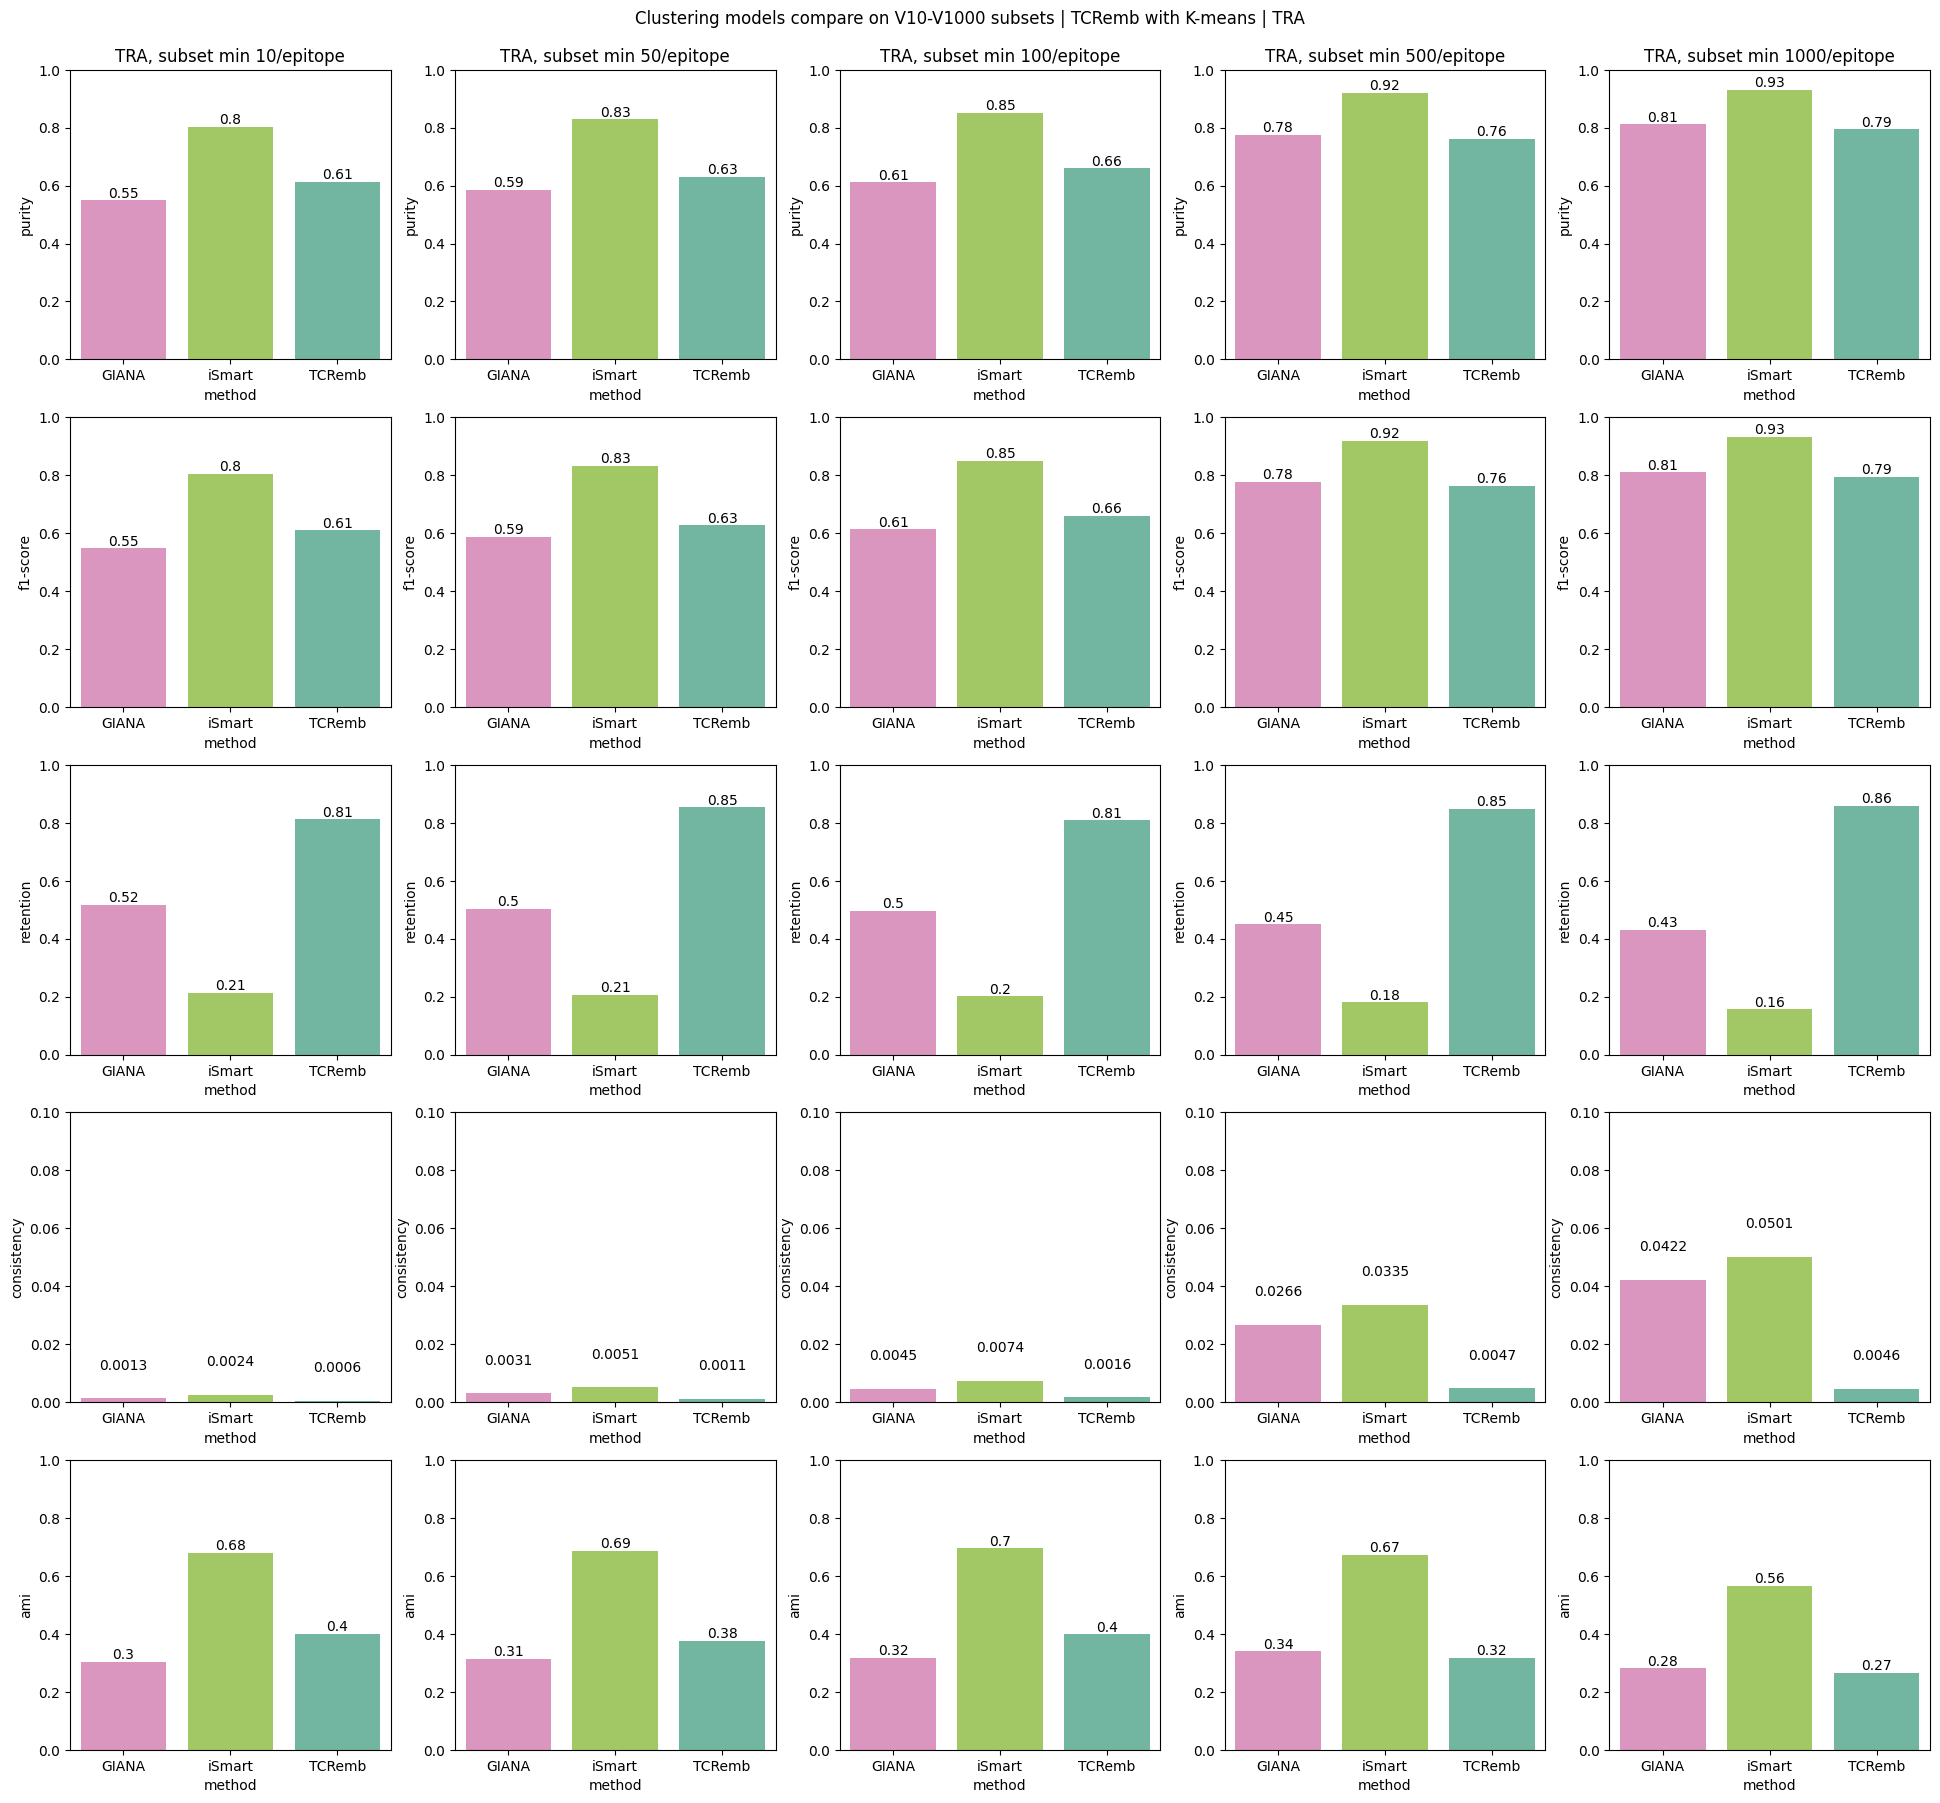

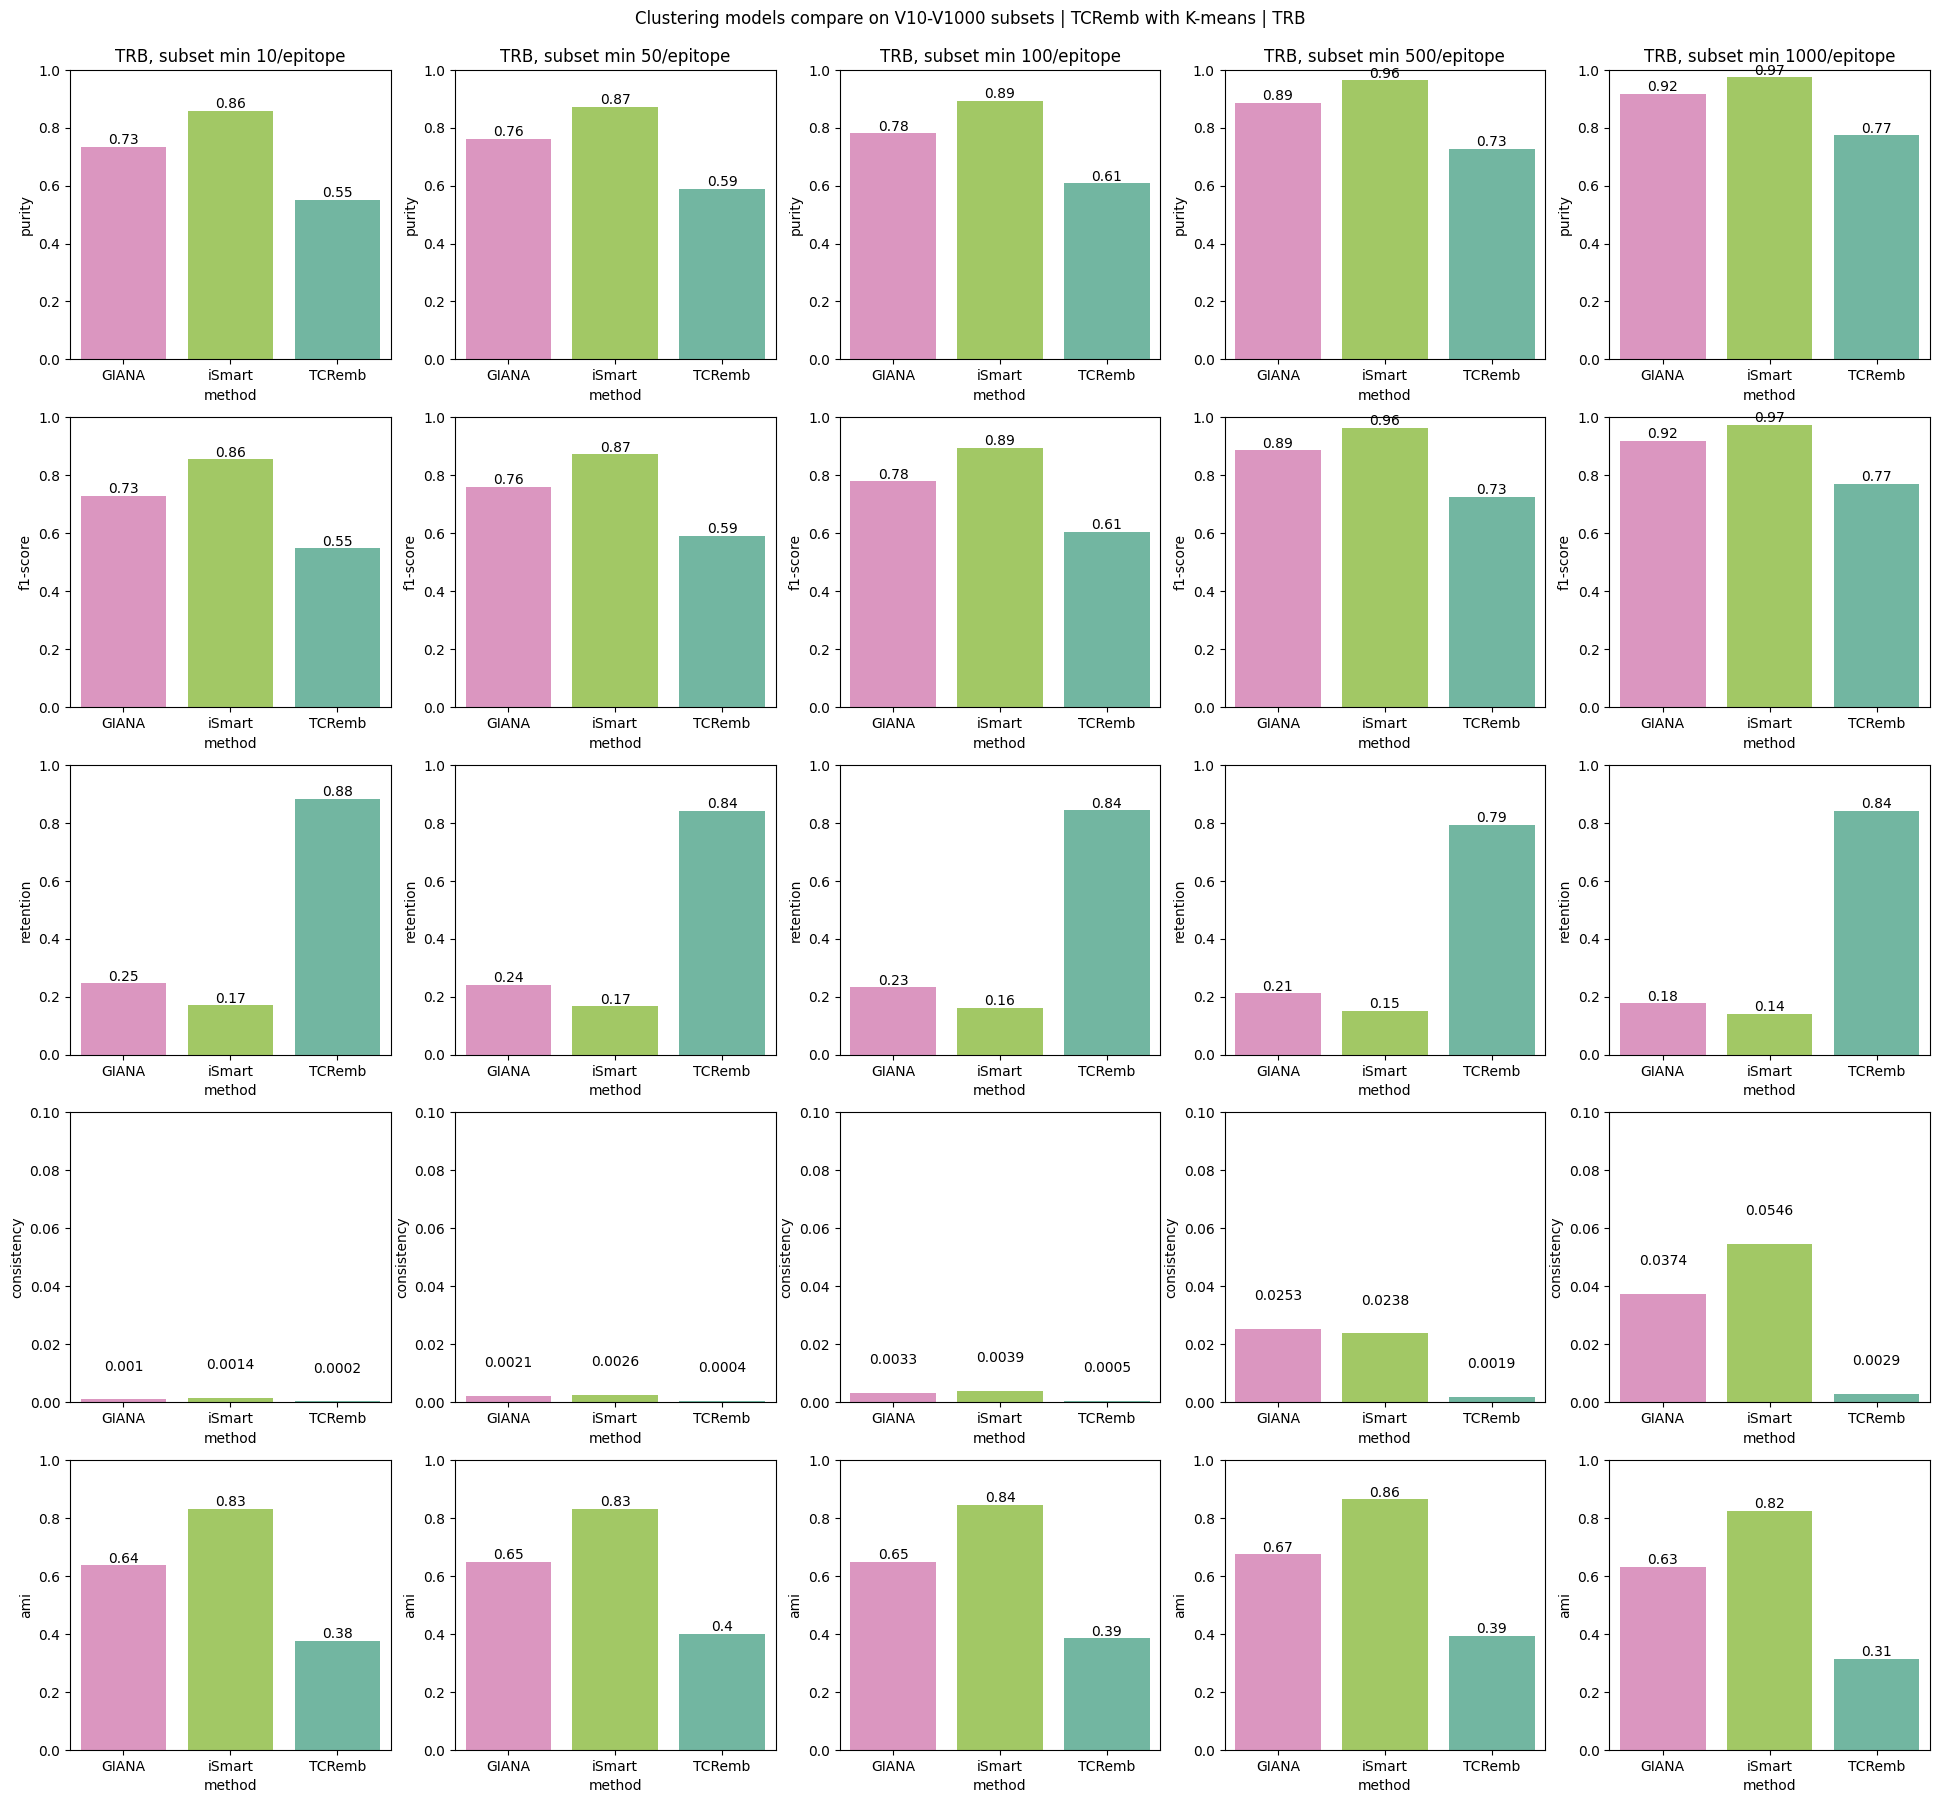

In [30]:
chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with K-means | {chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')    
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"figures/fig5_kmeans_{chain}.png")

chain = 'TRB'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with K-means | {chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"figures/fig5_kmeans_{chain}.png")

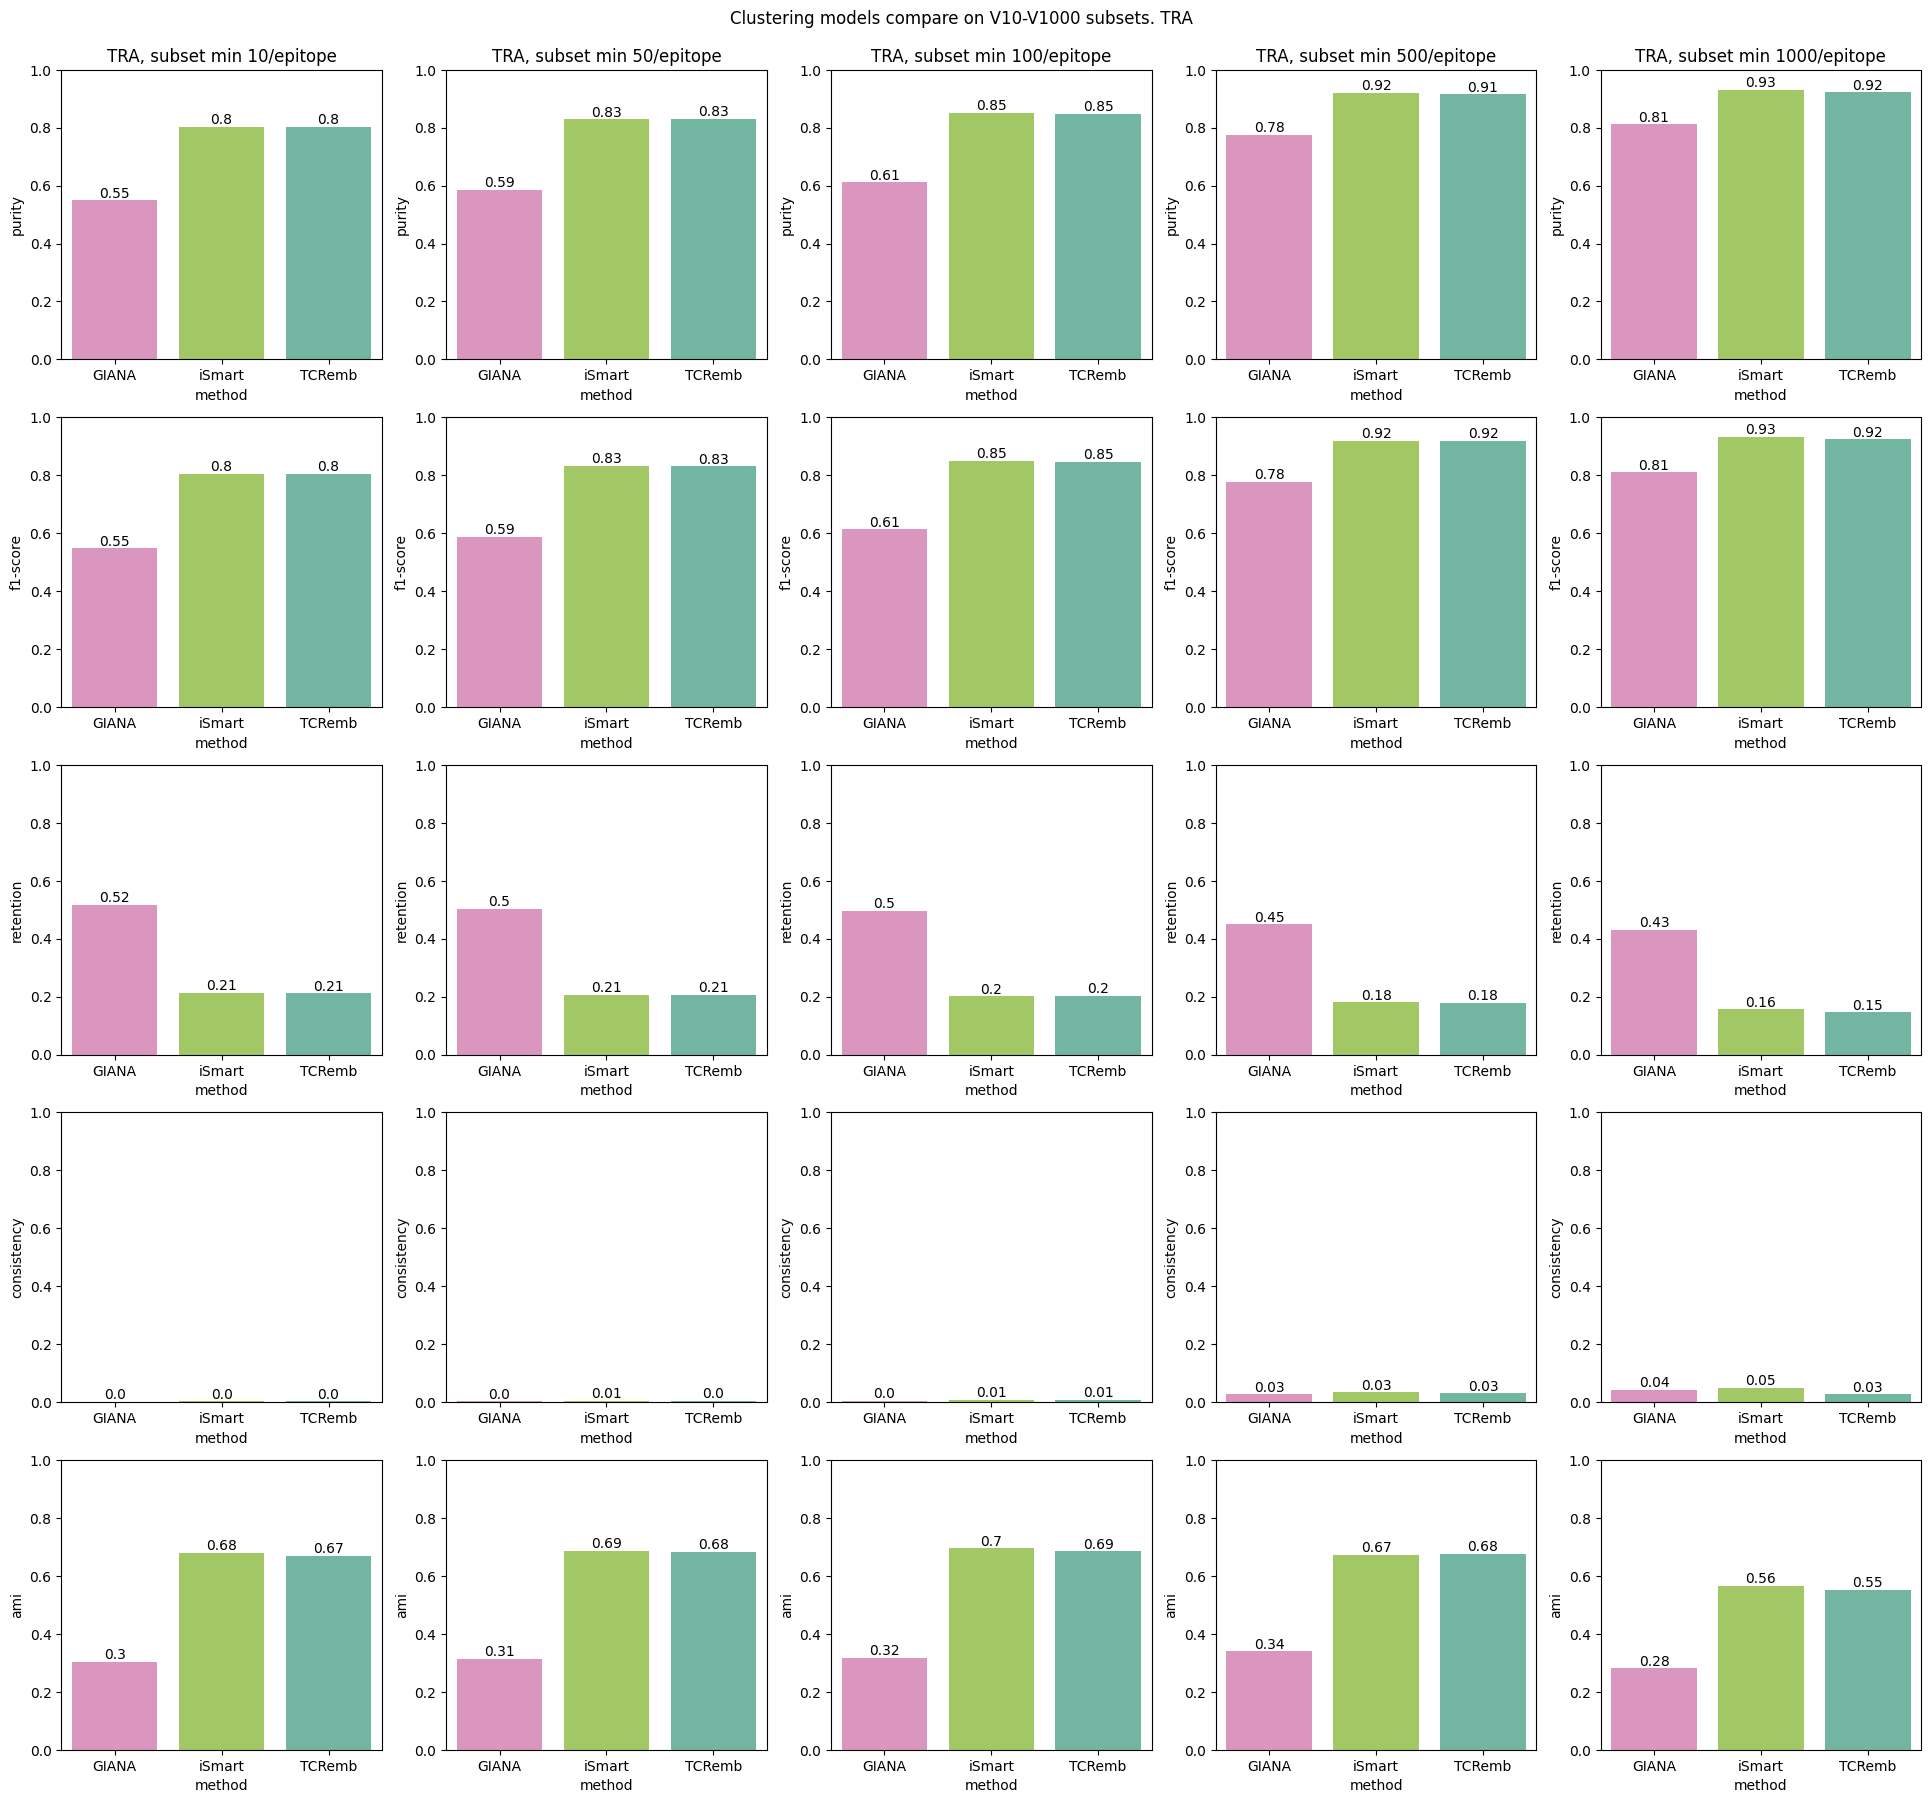

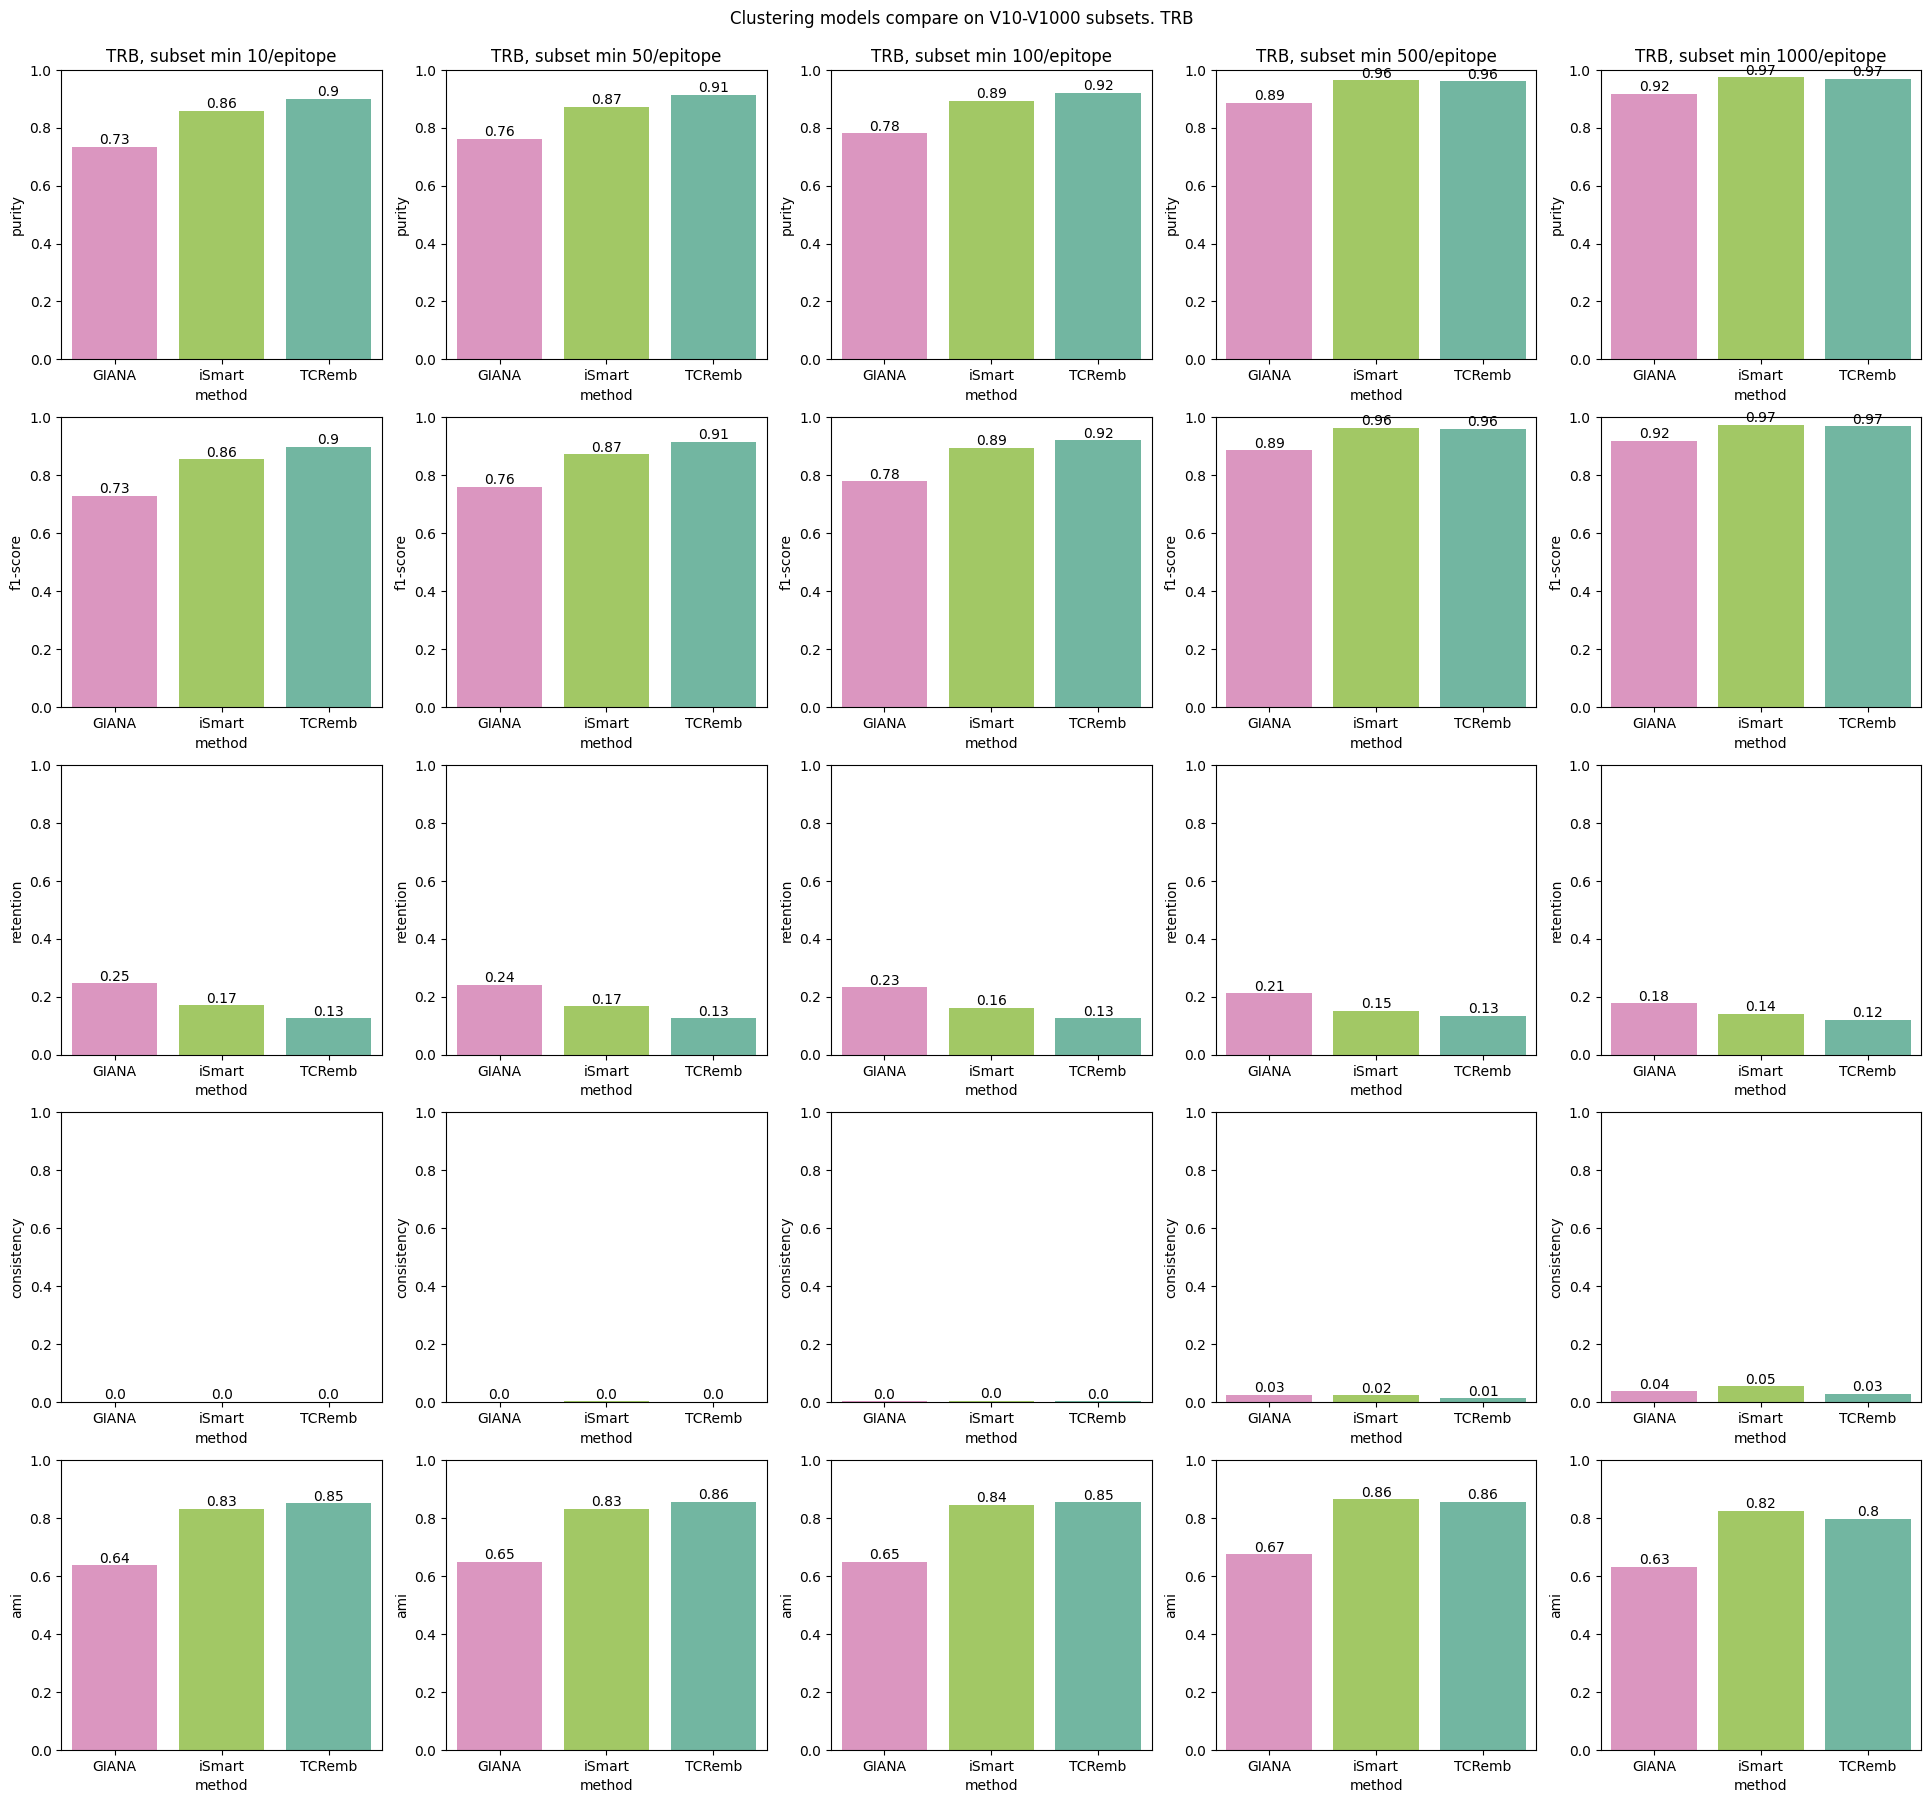

In [51]:
chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan | {chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')    
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"figures/fig5_dbscan_{chain}.png")

chain = 'TRB'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan |{chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"figures/fig5_dbscan_{chain}.png")

In [ ]:
chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (20,18))
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    ax_n+=1

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

In [ ]:
chain = 'TRA'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_enriched[chain]).T])
#metrics_v[chain]['method'] = metrics_v[chain].index

chain = 'TRB'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_enriched[chain]).T])

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

plt.savefig(f"figures/fig4_3.png")

# Classification

## ATM_TCR

2650 11772 505 6706
accuracy   0.4325
auc        0.6519
f1macro    0.4118
f1micro    0.4325
loss       442818.7955
precision0 0.8399
precision1 0.3629
recall0    0.1837
recall1    0.9300

In [ ]:
atm_results_path = '/home/ykremlyakova/apps/ATM-TCR/result/pred_my_model_vdjdb_trb_atmtcr_test.csv'
real_test_path = '/home/ykremlyakova/projects/tcr_emb/data/data_preped/vdjdb_trb_atmtcr_test.csv'

In [ ]:
!pwd

In [ ]:
real_test = pd.read_csv(real_test_path,header=None)
real_test

In [ ]:
atm = pd.read_csv(atm_results_path, sep='\t',header=None)
atm = atm.rename({0:'antigen.epitope',1:'cdr3aa',2:'bind',3:'pred'},axis=1)

In [ ]:
epitopes_list = ['CINGVCWTV',
 'ELAGIGILTV',
 'FRDYVDRFYKTLRAEQASQE',
 'GILGFVFTL',
 'GLCTLVAML',
 'KRWIILGLNK',
 'LLLGIGILV',
 'LLWNGPMAV',
 'NLVPMVATV',
 'PKYVKQNTLKLAT',
 'SPRWYFYYL',
 'TFEYVSQPFLMDLE',
 'TPRVTGGGAM',
 'TTDPSFLGRY',
 'YLQPRTFLL']

In [ ]:
atm_e = atm[atm['antigen.epitope'].isin(epitopes_list)]

In [ ]:
#atm_e = atm_e[atm_e['bind']==1]

In [ ]:
roc_res = []
for e in epitopes_list:
    r={}
    r['class']= e
    r['roc_auc'] = ml_utils.roc_auc_count_binary(atm_e[atm_e['antigen.epitope']==e]['bind'], atm_e[atm_e['antigen.epitope']==e]['pred'])
    roc_res.append(r)

In [ ]:
roc_res


In [ ]:
atm_e[atm_e['pred'].isna()]